# MNIST Classification using Predictive Coding

This notebook implements a Predictive Coding Network (PCN) for MNIST digit classification.

## Setup and Imports
The following cell sets up our environment with necessary PyTorch imports and checks for GPU availability.


In [16]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# to display matplotlib plots inline (directly below the cell)
%matplotlib inline


Using device: cpu


## Data Loading and Preprocessing

Here we:
1. Define data transformations (convert to tensor and normalize)
2. Load the MNIST dataset for training and testing
3. Create data loaders
4. Print dataset statistics

The MNIST dataset contains 60,000 training images and 10,000 test images of handwritten digits (0-9).


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),                   
    transforms.Normalize((0.1307,), (0.3081,))  
])

# get the MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform
)

# create data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size:     {len(test_dataset)}")
print(f"Number of batches in training: {len(train_loader)}")
print(f"Number of batches in testing:  {len(test_loader)}")


Training dataset size: 60000
Test dataset size:     10000
Number of batches in training: 1875
Number of batches in testing:  313


### visualize a batch of training images to understand our input data, vertify the data loaded correctly and see examples. 



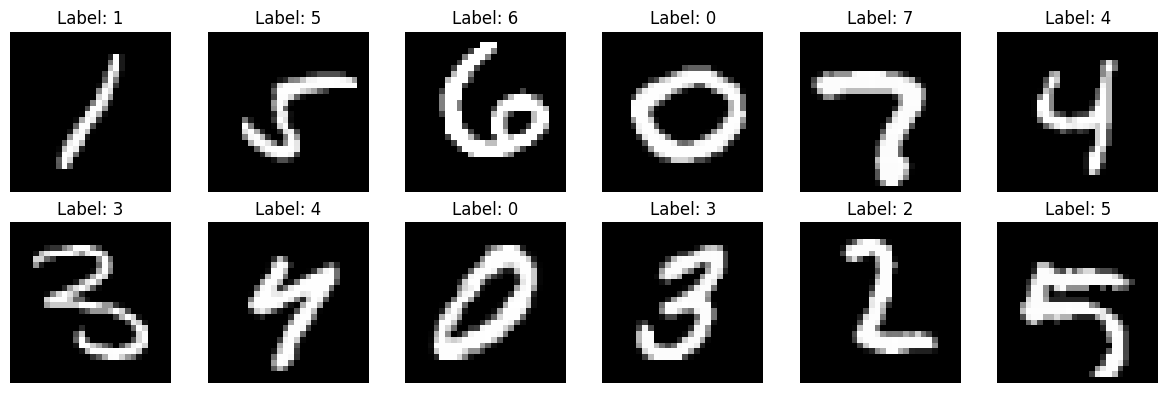

In [3]:
# get a batch of training data
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i + 1)
    # remove normalization
    img = images[i].squeeze()
    img = img * 0.3081 + 0.1307
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {labels[i].item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()


## Predictive Coding Architecture

We define a simple architecture for our Predictive Coding Network:
- Input layer: 784 units (28x28 flattened images)
- Hidden layer 1: 256 units with ReLU activation
- Hidden layer 2: 128 units with ReLU activation
- Hidden layer 3: 64 units with ReLU activation
- Output layer: 10 units (one per digit)

Key features:
- ReLU activation functions
- Prediction function for forward pass
- Lateral connections in hidden layers 2 and 3 


In [4]:
class PCMNISTNet(nn.Module):
    def __init__(self):
        super(PCMNISTNet, self).__init__()
        self.W1 = nn.Linear(28*28, 256, bias=False)
        self.W2 = nn.Linear(256, 128, bias=False)
        self.W3 = nn.Linear(128, 64, bias=False)
        self.W4 = nn.Linear(64, 10, bias=False)
        # lateral connections for hidden layers 2 and 3
        self.L2 = nn.Linear(128, 128, bias=False)
        self.L3 = nn.Linear(64, 64, bias=False)
        for layer in [self.L2, self.L3]:
            nn.init.normal_(layer.weight, mean=0.0, std=0.01)
            mask = ~torch.eye(layer.weight.shape[0], dtype=torch.bool)
            layer.weight.data *= mask # to avoid self connection 
        self.act = torch.relu

    def predict(self, x, lateral_strength=0.1):
        # forward pass to initialize latent states
        z0 = x.view(x.size(0), -1)
        z1 = self.act(self.W1(z0))
        z2_ff = self.act(self.W2(z1))
        lat2 = self.act(self.L2(z2_ff))
        z2 = z2_ff + lateral_strength * lat2
        z3_ff = self.act(self.W3(z2))
        lat3 = self.act(self.L3(z3_ff))
        z3 = z3_ff + lateral_strength * lat3
        z4 = self.W4(z3) # we want raw outputs here so no activation
        return [z0, z1, z2, z3, z4]

# Instantiate model
model = PCMNISTNet().to(device)
print(model)

PCMNISTNet(
  (W1): Linear(in_features=784, out_features=256, bias=False)
  (W2): Linear(in_features=256, out_features=128, bias=False)
  (W3): Linear(in_features=128, out_features=64, bias=False)
  (W4): Linear(in_features=64, out_features=10, bias=False)
  (L2): Linear(in_features=128, out_features=128, bias=False)
  (L3): Linear(in_features=64, out_features=64, bias=False)
)


## Predictive Coding Training Function

This function implements the predictive coding learning algorithm with lateral connections:

- Runs multiple inference steps to iteratively update hidden states and minimize prediction errors.
- Updates both feedforward and lateral weights based on final prediction errors.
- Hyperparameters: `inference_steps`, `alpha` (latent state LR), `eta` (weight LR), `lateral_strength`.

In [5]:
inference_steps = 10
alpha = 0.05 # latent state learning rate
eta = 0.01 # weight learning rate
lateral_strength = 0.1

@torch.no_grad()
def pc_train_batch(model, x, y_onehot):
    zs = model.predict(x, lateral_strength=lateral_strength)
    Ws = [model.W1, model.W2, model.W3, model.W4]
    Ls = [model.L2, model.L3]
    L = len(Ws)
    zs[L] = y_onehot # clamps z4 with the true labels
    for _ in range(inference_steps):
        errors = [None]*(L+1)
        for l in range(1, L+1):
            if l < L:
                ff_pred = model.act(Ws[l-1](zs[l-1]))
                if l == 2:
                    lat_pred = model.act(Ls[0](zs[l]))
                    pred = ff_pred + lateral_strength * lat_pred
                elif l == 3:
                    lat_pred = model.act(Ls[1](zs[l]))
                    pred = ff_pred + lateral_strength * lat_pred
                else:
                    pred = ff_pred
            else:
                pred = Ws[l-1](zs[l-1])
            errors[l] = zs[l] - pred
        # updating the activation states of the hidden layers
        for l in range(1, L):
            # the layer aligning itself with what the layer below says it should be
            td = -errors[l] 
            # push zl in the direction that would reduce the error one layer up
            bu = errors[l+1] @ Ws[l].weight 
            if l == 2:
                lat = lateral_strength * (errors[l] @ Ls[0].weight)
                zs[l] += alpha * (td + bu + lat)
            elif l == 3:
                lat = lateral_strength * (errors[l] @ Ls[1].weight)
                zs[l] += alpha * (td + bu + lat)
            else:
                zs[l] += alpha * (td + bu)
    final_errors = []
    for l in range(1, L+1):
        if l < L:
            ff_pred = model.act(Ws[l-1](zs[l-1]))
            if l == 2:
                lat_pred = model.act(Ls[0](zs[l]))
                pred = ff_pred + lateral_strength * lat_pred
            elif l == 3:
                lat_pred = model.act(Ls[1](zs[l]))
                pred = ff_pred + lateral_strength * lat_pred
            else:
                pred = ff_pred
        else:
            pred = Ws[l-1](zs[l-1])
        final_errors.append(zs[l] - pred)
    # updating weights
    for i, W in enumerate(Ws):
        grad = final_errors[i].t() @ zs[i]
        W.weight.data += eta * (grad / x.size(0)) # we divide by the batch size to normalize the average gradient
    
    # Update lateral weights for layers 2 and 3
    for i, L_layer in enumerate(Ls):
        l = i + 2
        grad = final_errors[l-1].t() @ zs[l]
        mask = ~torch.eye(L_layer.weight.shape[0], dtype=torch.bool, device=grad.device)
        grad = grad * mask # to avoid self connection
        L_layer.weight.data += eta * lateral_strength * (grad / x.size(0)) # we divide by the batch size to normalize the average gradient
    return final_errors, zs

## Training Loop

- Trains the predictive coding network for several epochs.
- Tracks and prints the average prediction error and test accuracy after each epoch.
- Evaluates the model on the test set at the end of every epoch.
- Stores prediction errors and test accuracies for later analysis or plotting.

In [6]:
num_epochs = 5
prediction_errors = []
test_accuracies = []

for epoch in range(1, num_epochs+1):
    total_error = 0.0
    batches = 0

    model.train()
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
        images, labels = images.to(device), labels.to(device)
        y_onehot = torch.zeros(images.size(0), 10, device=device)
        y_onehot.scatter_(1, labels.view(-1,1), 1.0)

        final_errors, _ = pc_train_batch(model, images, y_onehot)
        batch_error = final_errors[-1].abs().mean().item() #computes the average absolute error across the batch
        total_error += batch_error
        batches += 1

    avg_error = total_error / batches
    prediction_errors.append(avg_error)

    # Test accuracy
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            zs = model.predict(images)
            preds = zs[-1].argmax(dim=1) # changes logits to classes
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)

    test_acc = test_correct / test_total
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch}:")
    print(f"  Prediction error: {avg_error:.4f}")
    print(f"  Test accuracy: {test_acc:.4f}")

Epoch 1:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1:
  Prediction error: 0.1232
  Test accuracy: 0.6213


Epoch 2:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2:
  Prediction error: 0.0908
  Test accuracy: 0.7401


Epoch 3:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3:
  Prediction error: 0.0688
  Test accuracy: 0.8003


Epoch 4:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4:
  Prediction error: 0.0560
  Test accuracy: 0.8268


Epoch 5:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5:
  Prediction error: 0.0481
  Test accuracy: 0.8402



### Evaluate the trained model's performance on the test set



In [7]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        zs = model.predict(images)
        preds = zs[-1].argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test accuracy: {correct/total:.4f}")


Test accuracy: 0.8402


## Prediction Examples

Visualize model predictions on test data:
- Green titles indicate correct predictions
- Red titles indicate incorrect predictions
- Format: P:X T:Y where X is predicted digit and Y is true digit


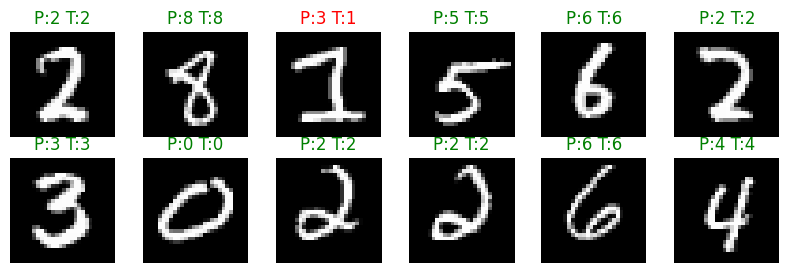

In [15]:
import random

test_batches = list(test_loader)
test_images, test_labels = random.choice(test_batches)
test_images = test_images.to(device)
zs = model.predict(test_images)
preds = zs[-1].argmax(dim=1)

fig = plt.figure(figsize=(10, 3))
for i in range(12):
    ax = fig.add_subplot(2, 6, i + 1)
    img = test_images[i].cpu().squeeze() * 0.3081 + 0.1307
    ax.imshow(img, cmap='gray')
    color = 'green' if preds[i]==test_labels[i] else 'red'
    ax.set_title(f"P:{preds[i].item()} T:{test_labels[i].item()}", color=color)
    ax.axis('off')
plt.show()


## Results Visualization

4 key visualizations to understand model performance:

1. **Prediction Error Plot**:
   - Shows how well the model minimizes prediction errors over epochs

2. **Test Accuracy Plot**:
   - Shows model's generalization performance

3. **Confusion Matrix**:
   - Shows which digits are commonly confused

4. **Per-Class Accuracy**:
   - Shows accuracy for each digit (0-9)


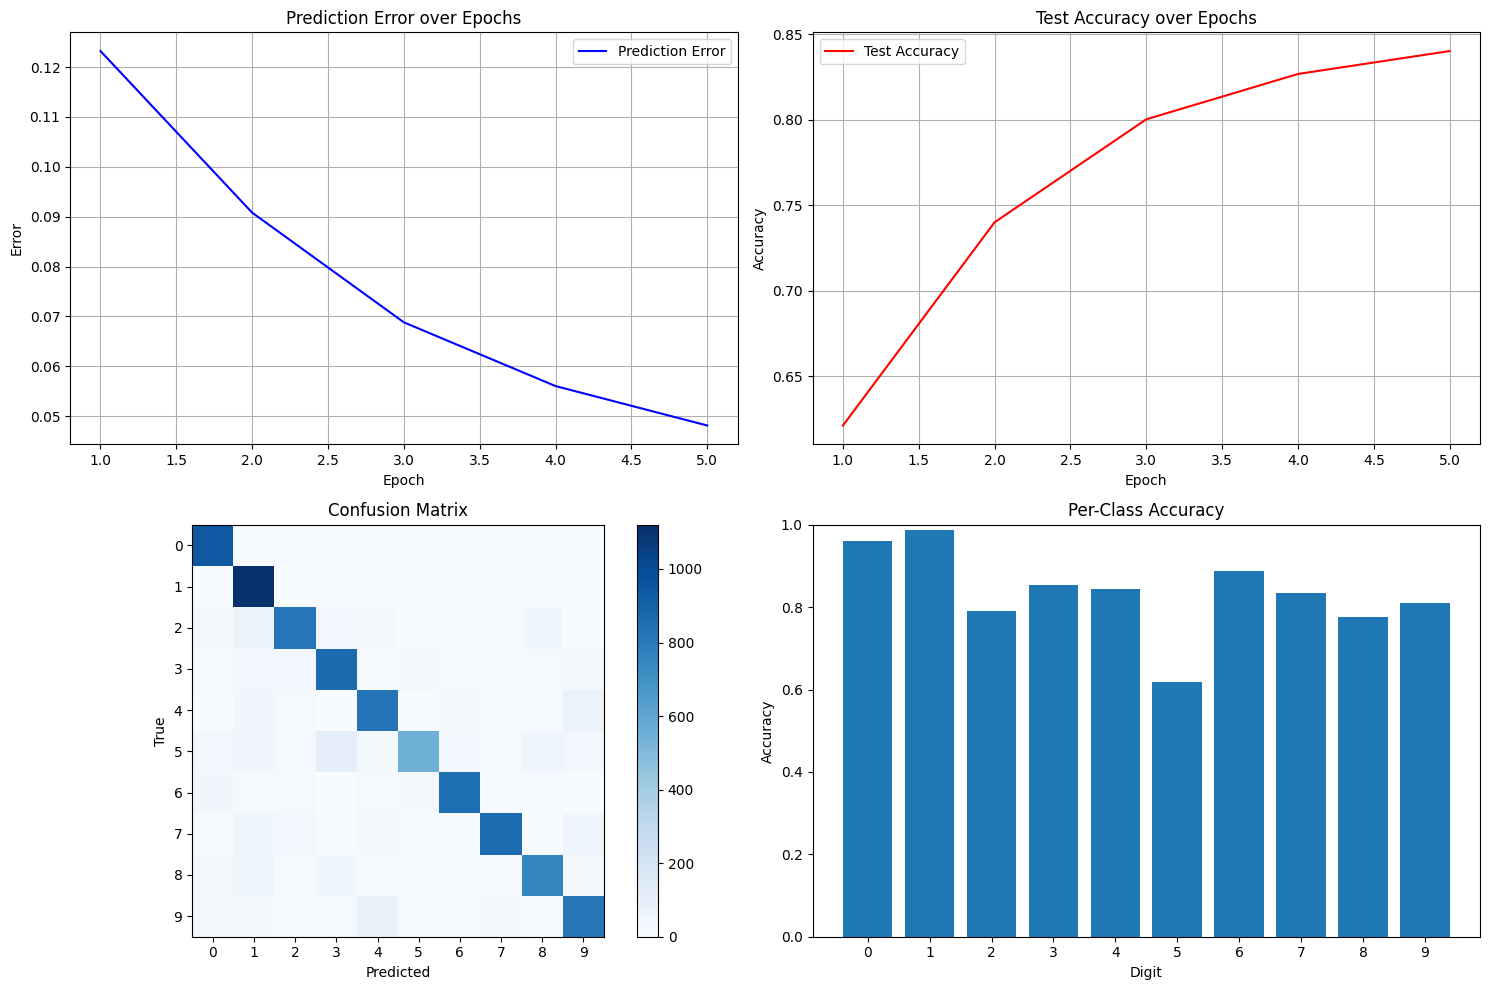


Per-class accuracies:
Digit 0: 0.9602
Digit 1: 0.9868
Digit 2: 0.7897
Digit 3: 0.8545
Digit 4: 0.8442
Digit 5: 0.6177
Digit 6: 0.8883
Digit 7: 0.8356
Digit 8: 0.7752
Digit 9: 0.8107


In [ ]:
plt.figure(figsize=(15, 10))

# Plot 1: Prediction Error
plt.subplot(2, 2, 1)
plt.plot(range(1, num_epochs + 1), prediction_errors, 'b-', label='Prediction Error')
plt.title('Prediction Error over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.grid(True)
plt.legend()

# Plot 2: Test Accuracy
plt.subplot(2, 2, 2)
plt.plot(range(1, num_epochs + 1), test_accuracies, 'r-', label='Test Accuracy')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Plot 3: Confusion Matrix
plt.subplot(2, 2, 3)
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        zs = model.predict(images)
        preds = zs[-1].argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

conf_matrix = np.zeros((10, 10))
for t, p in zip(y_true, y_pred):
    conf_matrix[t, p] += 1

plt.xticks(np.arange(10), [str(i) for i in range(10)])
plt.yticks(np.arange(10), [str(i) for i in range(10)])
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

# Plot 4: Per-Class Accuracy
plt.subplot(2, 2, 4)
per_class_acc = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
plt.bar(range(10), per_class_acc)
plt.title('Per-Class Accuracy')
plt.xlabel('Digit')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(np.arange(10), [str(i) for i in range(10)])
plt.tight_layout()
plt.show()

print("\nPer-class accuracies:")
for digit, acc in enumerate(per_class_acc):
    print(f"Digit {digit}: {acc:.4f}")
